In [ ]:
!pip install pyspellchecker
!pip install --upgrade scipy
!pip install numpy
!pip install emoji
!pip install nltk
!pip install spacy==3.5.0
!pip install spacy-transformers==1.1.5
!pip install transformers datasets accelerate bitsandbytes
!pip install -U sentence-transformers
!pip install swifter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 13.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.6/152.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!python3 -m spacy download en_core_web_sm
!python3 -m spacy download ru_core_news_sm

2024-11-15 20:24:14.059058: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-15 20:24:14.163594: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-15 20:24:14.185511: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 20:24:14.245772: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-15 20:24:16.769043: W tensorflow/compiler/tf2

In [ ]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt
from spellchecker import SpellChecker
from sklearn.metrics import classification_report
import re
import nltk
from nltk.corpus import stopwords
import emoji
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from transformers import BertTokenizerFast

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Load the spaCy models
nlp_en = spacy.load('en_core_web_sm')
nlp_ru = spacy.load('ru_core_news_sm')

In [ ]:
spell_en = SpellChecker(language='en')
spell_ru = SpellChecker(language='ru')

# Define Classes and Functions to be used throughout Notebook

In [ ]:
import emoji

# Cell 2: Data Preprocessing Class
class DataPreprocessor:
    def __init__(self, lang):
        self.lang = lang
        self.spell_checker = SpellChecker(language=self.lang)

    def clean_text(self, text):
        text = text.lower()
        text = self.remove_special_chars(text)
        #text = self.spell_check(text)
        text = self.remove_stop_words(text)
        #text = self.apply_encoding(text)
        return text

    def remove_special_chars(self, text):
        # Remove URLs, mentions, hashtags, and non-alphanumeric characters but preserve spaces
        text = re.sub(r'(https?://\S+|www\.\S+|@\S+|#\S+)', '', text)  # Remove URLs, mentions, hashtags
        text = re.sub(r'[^a-zA-Zа-яА-Я\s]', '', text)  # Remove non-alphanumeric characters but preserve spaces (including Cyrillic for Russian)
        return text

    def spell_check(self, text):
        misspelled = self.spell_checker.unknown(text.split())
        for word in misspelled:
            correction = self.spell_checker.correction(word)
            if correction is not None:
                text = text.replace(word, correction)
        return text

    def apply_encoding(self, text):
        text = str(text)
        return text.encode('utf-8', errors='replace').decode('utf-8')

    def remove_stop_words(self, text):
        words = text.split()

        if self.lang == 'en':
            english_stop_words = set(stopwords.words('english'))
            words = [word for word in words if word not in english_stop_words]

        elif self.lang == 'ru':
            russian_stop_words = set(stopwords.words('russian'))
            words = [word for word in words if word not in russian_stop_words]

        return ' '.join(words)


In [ ]:
import pandas as pd

def extract_sentiment(doc, lang):
        if lang == 'English':
            if '1 star' in doc.cats or '2 star' in doc.cats:
                  return 'positive'
            elif '4 star' in doc.cats or '5 star' in doc.cats:
                  return 'positive'
            elif '3 star' in doc.cats:
                  return 'neutral'
            else:
                  return 'neutral'

        elif lang == 'Russian':
          if doc:
              if 'positive' in doc.cats:
                  return 'positive'
              elif 'negative' in doc.cats:
                  return 'negative'
              else:
                  return 'neutral'
          else:
              return None

def analyze_long_texts_batch(texts, chunk_size=512, overlap=128, batch_size=10):
    all_sentiments = []
    for i in range(0, len(texts), batch_size):
        print("iterating...")
        batch_texts = texts[i:i + batch_size]
        batch_sentiments = []
        for text in batch_texts:
            chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size - overlap)]
            # Process all chunks in a single batch using nlp.pipe
            chunk_sentiments = [extract_sentiment(doc, 'Russian') for doc in nlp_ru.pipe(chunks, batch_size=len(chunks))]
            batch_sentiments.append(max(set(chunk_sentiments), key=chunk_sentiments.count) if chunk_sentiments else "NEUTRAL")
        all_sentiments.extend(batch_sentiments)
    return all_sentiments

In [ ]:
import pandas as pd
from transformers import AutoModelForMaskedLM, AutoTokenizer
import torch
import random

class DataAugmentor:
      def __init__(self, lang):
        self.lang = lang
        self.tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
        self.model = AutoModelForMaskedLM.from_pretrained("DeepPavlov/rubert-base-cased")

      def replace_word_with_synonym(self, text, top_k=5):
                tokens = self.tokenizer.tokenize(text)

                candidate_indices = [i for i, token in enumerate(tokens) if token not in self.tokenizer.all_special_tokens] # Select a random word (ignoring special tokens) and its index
                if not candidate_indices:
                    return [text]

                random_idx = random.choice(candidate_indices)
                word_to_mask = tokens[random_idx]

                # Replace the selected word with [MASK]
                tokens[random_idx] = self.tokenizer.mask_token
                masked_text = self.tokenizer.convert_tokens_to_string(tokens)

                inputs = self.tokenizer(masked_text, return_tensors="pt") # Prepare input for the model
                mask_token_index = torch.where(inputs.input_ids == self.tokenizer.mask_token_id)[1]

                with torch.no_grad():
                    token_logits = self.model(**inputs).logits
                mask_token_logits = token_logits[0, mask_token_index, :]
                top_tokens = torch.topk(mask_token_logits, top_k, dim=1).indices[0].tolist()

                synonyms = [self.tokenizer.decode([token]).strip() for token in top_tokens]

                sentences_with_synonyms = []
                for synonym in synonyms:
                    # Replace the masked token with the synonym
                    new_tokens = tokens[:]
                    new_tokens[random_idx] = synonym
                    new_sentence = self.tokenizer.convert_tokens_to_string(new_tokens)
                    sentences_with_synonyms.append(new_sentence)

                return sentences_with_synonyms


      def random_deletion(self, text, p=0.1):
            text = str(text)
            words = text.split()
            if len(words) == 1:
                return text
            remaining_words = [word for word in words if random.uniform(0, 1) > p]
            return ' '.join(remaining_words) if remaining_words else text

In [ ]:
def apply_sentiment_analysis(row):
    content = row['cleaned_text']
    language = row['language']

    if language == 'English':
        doc = nlp_en(content)
        sentiment = extract_sentiment(doc, 'English')
    elif language == 'Russian':
        doc = nlp_ru(content)
        sentiment = extract_sentiment(doc, 'Russian')
    else:
        sentiment = None  # Skip if language is not English or Russian

    return sentiment

In [ ]:
def apply_sentiment_analysis_for_russian_sentiment_analysis_dataset(row):
    content = row['text']
    if len(content) > 512:
        sentiment = analyze_long_texts_batch(content)
    else:
        doc = nlp_ru(content)
        sentiment = extract_sentiment(doc, 'Russian')
    return sentiment

In [ ]:
from enum import Enum

class Language(Enum):
    ENGLISH = "English"
    RUSSIAN = "Russian"
    # could be extended depending on the datasets

# Load Troll Tweet Dataset & Run Sentiment Analysis with Pre-trained Models

In [69]:
columns_to_del = ['external_author_id', 'author', 'updates', 'account_type', 'new_june_2018', 'retweet', 'account_category']
russian_tweet_set = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle russian troll tweets/IRAhandle_tweets_1.csv')
russian_tweet_set = russian_tweet_set.drop(columns=columns_to_del)

display(russian_tweet_set)

,content,region,language,publish_date,harvested_date,following,followers,post_type
0,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,NaN
1,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,NaN
2,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,RETWEET
3,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,NaN
4,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,RETWEET
...,...,...,...,...,...,...,...,...
381011,"ICYMI, @SabrinaAnnLynn dropped a lyric video f...",United States,English,3/7/2017 0:25,3/7/2017 0:25,694,711,RETWEET
381012,"WorldStarHipHop Founder Lee ""Q"" O'Denat Dies a...",United States,English,3/7/2017 0:25,3/7/2017 0:25,694,711,RETWEET
381013,“This world is but a canvas to our imagination...,United States,English,3/7/2017 0:25,3/7/2017 0:25,694,711,RETWEET
381014,House Republicans release bill that would dism...,United States,English,3/7/2017 0:25,3/7/2017 0:25,694,711,RETWEET


Filter out all languages that aren't English or Russian

In [70]:
russian_tweet_set = russian_tweet_set[russian_tweet_set['language'].isin(['English', 'Russian'])]
russian_tweet_set = russian_tweet_set.drop_duplicates()
display(russian_tweet_set)

,content,region,language,publish_date,harvested_date,following,followers,post_type
0,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,NaN
1,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,NaN
2,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,RETWEET
3,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,NaN
4,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,RETWEET
...,...,...,...,...,...,...,...,...
381011,"ICYMI, @SabrinaAnnLynn dropped a lyric video f...",United States,English,3/7/2017 0:25,3/7/2017 0:25,694,711,RETWEET
381012,"WorldStarHipHop Founder Lee ""Q"" O'Denat Dies a...",United States,English,3/7/2017 0:25,3/7/2017 0:25,694,711,RETWEET
381013,“This world is but a canvas to our imagination...,United States,English,3/7/2017 0:25,3/7/2017 0:25,694,711,RETWEET
381014,House Republicans release bill that would dism...,United States,English,3/7/2017 0:25,3/7/2017 0:25,694,711,RETWEET


Preprocess Text

In [71]:
# Process data
import swifter

russian_tweet_set_processed = russian_tweet_set.head(10000).copy()
preprocessor = DataPreprocessor(lang='ru')
#russian_tweet_set['cleaned_text'] = russian_tweet_set['content'].apply(preprocessor.clean_text)
russian_tweet_set_processed['cleaned_text'] = russian_tweet_set_processed['content'].swifter.apply(preprocessor.clean_text)

display(russian_tweet_set_processed)

Pandas Apply:   0%|          | 0/10000 [00:00<?, ?it/s]

,content,region,language,publish_date,harvested_date,following,followers,post_type,cleaned_text
0,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,NaN,we have a sitting democrat us senator on trial...
1,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,NaN,marshawn lynch arrives to game in antitrump sh...
2,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,RETWEET,daughter of fallen navy sailor delivers powerf...
3,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,NaN,just in president trump dedicates presidents c...
4,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,RETWEET,respecting our national anthem
...,...,...,...,...,...,...,...,...,...
13488,Remember: Worship is a heart overflowing with ...,United States,English,10/6/2016 8:51,10/6/2016 8:51,997,1050,RETWEET,remember worship is a heart overflowing with p...
13489,If you don't have a home for your content or l...,United States,English,10/7/2016 0:00,10/7/2016 0:01,997,1060,RETWEET,if you dont have a home for your content or lo...
13490,I promise to bring you guys into this with & o...,United States,English,10/7/2016 0:02,10/7/2016 0:03,997,1060,RETWEET,i promise to bring you guys into this with oly...
13491,Praying for those involved in #HurricaneMatthe...,United States,English,10/7/2016 0:03,10/7/2016 0:03,997,1060,RETWEET,praying for those involved in


# LOAD HUGGINGFACE MODELS INTO SPACY

In [ ]:
import spacy
from transformers import pipeline
from spacy.language import Language

@Language.factory("huggingface_sentiment")
def create_huggingface_sentiment_component(nlp, name, model_name):
    sentiment_analyzer = pipeline("sentiment-analysis", model=model_name)

    def component(doc):
        sentiment = sentiment_analyzer(doc.text)[0]
        label = sentiment['label']
        score = sentiment['score']

        doc.cats[label] = score
        return doc

    return component

# Load the spaCy models for English and Russian
nlp_en = spacy.load('en_core_web_sm')
nlp_ru = spacy.load('ru_core_news_sm')

# Add the Hugging Face sentiment components to each pipeline with specified models
nlp_en.add_pipe("huggingface_sentiment", config={"model_name": "nlptown/bert-base-multilingual-uncased-sentiment"})
nlp_ru.add_pipe("huggingface_sentiment", config={"model_name": "blanchefort/rubert-base-cased-sentiment"})


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/943 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/499 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

<function __main__.create_huggingface_sentiment_component.<locals>.component(doc)>

# Process for running Pretrained Model
1.   For each row of tweets in csv, run the sentiment analysis depending on language

2.   Save the sentiment score in a new column 'Sentiment'

3. Then use this DataFrame to make visualisations & metrics



In [ ]:
russian_tweet_set_copy = russian_tweet_set_processed.copy()
russian_tweet_set_copy['sentiment'] = russian_tweet_set_copy.swifter.apply(apply_sentiment_analysis, axis=1)

display(russian_tweet_set_copy)

Pandas Apply:   0%|          | 0/10000 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/swifter/swifter.py", line 419, in apply
    tmp_df = func(sample, *args, **kwds)
  File "<ipython-input-11-8d32afda63bb>", line 5, in apply_sentiment_analysis
    if language == 'English':
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/generic.py", line 1577, in __nonzero__
    raise ValueError(
ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-f1b1143426aa>", line 2, in <cell line: 2>
    russian_tweet_set_copy['sentiment'] = russian_tweet_set_copy.swifter.apply(apply_sentiment_analysis, axis=1)
  File "/usr/local/lib/python3.10/dist-packages/swifte

TypeError: object of type 'NoneType' has no len()

# Visualise Results from Sentiment Analysis

In [ ]:
russian_tweet_set_copy['publish_date'] = pd.to_datetime(russian_tweet_set_copy['publish_date'])

russian_tweet_set_copy.set_index('publish_date', inplace=True)

daily_sentiment = russian_tweet_set_copy.groupby([pd.Grouper(freq='D'), 'sentiment']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
daily_sentiment.plot(ax=plt.gca(), marker='o', linestyle='-')
plt.title('Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Tweet Count')
plt.legend(title='Sentiment')
plt.show()

In [ ]:
# @title sentiment

from matplotlib import pyplot as plt
import seaborn as sns
russian_tweet_set_copy.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

russian_tweet_set_copy = russian_tweet_set_copy.reset_index()
plt.figure(figsize=(10, 6))
sns.countplot(data=russian_tweet_set_copy, x='sentiment', hue='language', palette='viridis')
plt.title('Sentiment Distribution by Language')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend(title='Language')
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.scatter(russian_tweet_set_copy.index, russian_tweet_set_copy['sentiment'],
            c=russian_tweet_set_copy['sentiment'], cmap='viridis', alpha=0.6)

plt.title('Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.yticks([-1, 0, 1], ['Negative', 'Neutral', 'Positive'])
plt.colorbar(label='Sentiment')
plt.show()

# Run Tests for Test data

Load datasets with russian & sentiment

1. Convert JSON data into Pandas dataframe
2.   Run sentiment analysis for all tweets in DF & log sentiment predicted for each in new column
3.   Make function to iterate over every column & compared predicted to actual
4. Make functions to get accuracy metrics



In [ ]:
# 1. Convert JSON data into Pandas dataframe
import nltk
nltk.download('stopwords')
import pandas as pd
import json

with open('/content/drive/MyDrive/Colab Notebooks/sentiment-analysis-in-russian/train.json', 'r') as f:
    data = json.load(f)

df_russian_sentiment_tweets = pd.DataFrame(data)
df_russian_sentiment_tweets['text'] = df_russian_sentiment_tweets['text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
df_russian_sentiment_tweets['text'] = df_russian_sentiment_tweets['text'].apply(lambda x: x[:512] if len(x) > 512 else x)

preprocessor = DataPreprocessor(lang='ru')

average_length = df_russian_sentiment_tweets['text'].str.len().mean()
df_russian_sentiment_tweets['cleaned_text'] = df_russian_sentiment_tweets['text'].swifter.apply(preprocessor.clean_text)

display(df_russian_sentiment_tweets)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Pandas Apply:   0%|          | 0/8263 [00:00<?, ?it/s]

,text,id,sentiment,cleaned_text
0,Досудебное расследование по факту покупки ЕНПФ...,1945,negative,досудебное расследование факту покупки енпф па...
1,Медики рассказали о состоянии пострадавшего му...,1957,negative,медики рассказали состоянии пострадавшего мужч...
2,"Прошел почти год, как железнодорожным оператор...",1969,negative,прошел год железнодорожным операторам запретил...
3,По итогам 12 месяцев 2016 года на территории р...,1973,negative,итогам месяцев года территории республики выпу...
4,Астана. 21 ноября. Kazakhstan Today - Агентств...,1975,negative,астана ноября kazakhstan today агентство рк де...
...,...,...,...,...
8258,"Как мы писали еще весной, для увеличения сбыта...",10312,positive,писали весной увеличения сбыта также избегания...
8259,Но молодой министр национальной экономики Биши...,10313,negative,молодой министр национальной экономики бишимба...
8260,\n \nВ ЕНПФ назначен новый председатель правле...,10314,neutral,енпф назначен новый председатель правления еди...
8261,В Алматы у отделения банка произошло нападение...,10315,negative,алматы отделения банка произошло нападение стр...


In [ ]:
df_russian_sentiment_tweet_copy = df_russian_sentiment_tweets.head(100).copy() # Update to 10k
df_russian_sentiment_tweet_copy['predicted_sentiment'] = df_russian_sentiment_tweet_copy.swifter.apply(apply_sentiment_analysis_for_russian_sentiment_analysis_dataset, axis=1)

display(df_russian_sentiment_tweet_copy)

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

,text,id,sentiment,cleaned_text,predicted_sentiment
0,Досудебное расследование по факту покупки ЕНПФ...,1945,negative,досудебное расследование факту покупки енпф па...,neutral
1,Медики рассказали о состоянии пострадавшего му...,1957,negative,медики рассказали состоянии пострадавшего мужч...,neutral
2,"Прошел почти год, как железнодорожным оператор...",1969,negative,прошел год железнодорожным операторам запретил...,neutral
3,По итогам 12 месяцев 2016 года на территории р...,1973,negative,итогам месяцев года территории республики выпу...,neutral
4,Астана. 21 ноября. Kazakhstan Today - Агентств...,1975,negative,астана ноября kazakhstan today агентство рк де...,neutral
...,...,...,...,...,...
95,Национальным бюро по противодействию коррупции...,2149,negative,национальным бюро противодействию коррупции за...,neutral
96,В Национальном Банке состоялась очередная встр...,2150,neutral,национальном банке состоялась очередная встреч...,neutral
97,Сегодня в Астане более 200 детей с особыми пот...,2151,positive,сегодня астане детей особыми потребностями ста...,neutral
98,\n\n\nspectr.com.kz\nyk-news.kz\nАлматы\nАстан...,2152,positive,spectrcomkz yknewskz алматы астаны устькаменог...,neutral


In [ ]:
# @title sentiment

from matplotlib import pyplot as plt
import seaborn as sns
df_russian_sentiment_tweet_copy.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score


true_labels = df_russian_sentiment_tweet_copy['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})
predicted_labels = df_russian_sentiment_tweet_copy['predicted_sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

# Calculate the metrics
f1 = f1_score(true_labels, predicted_labels, average='weighted')
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)


print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

Run for only limited

In [60]:
# 1. Convert JSON data into Pandas dataframe

import pandas as pd
import json

with open('/content/drive/MyDrive/Colab Notebooks/sentiment-analysis-in-russian/train.json', 'r') as f:
    data = json.load(f)

df_russian_sentiment_tweets2 = pd.DataFrame(data)
df_russian_sentiment_tweets2 = df_russian_sentiment_tweets2[df_russian_sentiment_tweets2['text'].str.len() <= 512]
display(df_russian_sentiment_tweets2)

,text,id,sentiment
7,"""Самрук-Энерго"" в I квартале почти вдвое снизи...",1983,negative
12,"/KASE, 29.12.16/ – АО ""KEGOC"" (Астана), ценные...",2032,negative
19,Оплачивайте без комиссий «Казахтелеком» на сай...,2054,positive
20,"03.02.2017, 12:40\nНацбанк ставит для себя при...",2055,positive
26,"10.01.2017, 19:11\nСуд зарегистрировал заявлен...",2071,negative
...,...,...,...
8210,"25.11.2016, 12:14\nЕАБР предоставит банку ""Цен...",10264,positive
8214,Триумфаторами проведенного после перерыва в не...,10268,positive
8250,"22.12.2016, 16:36\nПенсионные накопления вклад...",10304,positive
8255,"01.02.2017, 13:37\n""Даму"" выделил Казкоммерцба...",10309,neutral


In [61]:
model_name = "fine_tuned_rubert_model"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

df_russian_sentiment_tweet_copy2 = df_russian_sentiment_tweets2.copy()
df_russian_sentiment_tweet_copy2['predicted_sentiment'] = df_russian_sentiment_tweet_copy2.swifter.apply(
    lambda row: apply_sentiment_analysis_for_finetuned(row, nlp_ru), axis=1
)

display(df_russian_sentiment_tweet_copy2)

TypeError: apply_sentiment_analysis_for_finetuned() missing 1 required positional argument: 'tokenizer'

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

true_labels = df_russian_sentiment_tweet_copy2['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})
predicted_labels = df_russian_sentiment_tweet_copy2['predicted_sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

f1 = f1_score(true_labels, predicted_labels, average='weighted')
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)


print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

F1 Score: 0.3108881207900567
Precision: 0.22999094548678262
Recall: 0.47957371225577267
Accuracy: 0.47957371225577267


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run Sentiment Analysis for other Test csv
1. Open both csv & join them into one DF based on ID
2. Run

In [ ]:
jigsaw_text_set = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/jigsaw-multilingual-toxic-comment-classification/test.csv')
jigsaw_text_set = jigsaw_text_set[jigsaw_text_set['lang'] == 'ru']
display(jigsaw_text_set)

,id,content,lang
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
18,18,", под вашу ответственность. NB: ЭСБЕ, значит, ...",ru
20,20,"Ошибаетесь Вы. Во-первых, текст должен быть п...",ru
26,26,"Отличная работа, спасибо. Я чуть доработал - п...",ru
28,28,левакофашист и путинский лизун ??? Как вообще ...,ru
...,...,...,...
63790,63790,Источник не авторитетный. Написано под редакци...,ru
63794,63794,См. Великий марш возвращения → Столкновения на...,ru
63799,63799,Предлагаю добавить вот ещё что про коммерческу...,ru
63801,63801,... получил сталинскую премию за музыку к филь...,ru


In [ ]:
jigsaw_sentiment_set = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/jigsaw-multilingual-toxic-comment-classification/test_labels.csv')
jigsaw_text_set = pd.merge(jigsaw_text_set, jigsaw_sentiment_set[['id', 'toxic']], on='id', how='left')
display(jigsaw_text_set)
# non-toxic = 0, toxic = 1

,id,content,lang,toxic
0,1,"Вполне возможно, но я пока не вижу необходимо...",ru,0
1,18,", под вашу ответственность. NB: ЭСБЕ, значит, ...",ru,1
2,20,"Ошибаетесь Вы. Во-первых, текст должен быть п...",ru,0
3,26,"Отличная работа, спасибо. Я чуть доработал - п...",ru,0
4,28,левакофашист и путинский лизун ??? Как вообще ...,ru,1
...,...,...,...,...
10943,63790,Источник не авторитетный. Написано под редакци...,ru,0
10944,63794,См. Великий марш возвращения → Столкновения на...,ru,0
10945,63799,Предлагаю добавить вот ещё что про коммерческу...,ru,0
10946,63801,... получил сталинскую премию за музыку к филь...,ru,1


# Fine Tune Model

1. Load dataset
2. Augment dataset - remove one word, replace synonyms
3. Run fine-tuning algorithm

Fine tune using jigsaw

In [ ]:
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import torch

model_name = "blanchefort/rubert-base-cased-sentiment"

train_jigsaw = jigsaw_text_set.head(100)

texts = train_jigsaw['content'].tolist()
labels = train_jigsaw['toxic'].tolist()

train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

train_data = Dataset.from_dict({"text": train_texts, "label": train_labels})
test_data = Dataset.from_dict({"text": test_texts, "label": test_labels})
dataset = DatasetDict({"train": train_data, "test": test_data})

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=64)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

def compute_metrics(pred):
    from sklearn.metrics import accuracy_score, f1_score
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {"accuracy": accuracy, "f1": f1}


training_args = TrainingArguments(
    output_dir="./results",
    report_to="none",  # Disable Weights & Biases integration
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=1,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    dataloader_num_workers=2,
    max_steps=2,
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

model.save_pretrained("fine_tuned_rubert_model")
tokenizer.save_pretrained("fine_tuned_rubert_model")

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-510b88fbcabe>:70: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
max_steps is given, it will override any value given in num_train_epochs


Epoch,Training Loss,Validation Loss,Accuracy,F1
0,No log,1.761631,0.300000,0.447619


('fine_tuned_rubert_model/tokenizer_config.json',
 'fine_tuned_rubert_model/special_tokens_map.json',
 'fine_tuned_rubert_model/vocab.txt',
 'fine_tuned_rubert_model/added_tokens.json',
 'fine_tuned_rubert_model/tokenizer.json')

# Run Tests Again

In [ ]:
def apply_sentiment_analysis_for_finetuned(row, model):
    content = row['text']
    if len(content) > 512:
        sentiment = analyze_long_texts_batch(content)
    else:
        doc = model(content)
        sentiment = extract_sentiment(doc, 'Russian')

    print(sentiment)
    return sentiment

In [ ]:
def apply_sentiment_analysis_for_finetuned(row, model):
    content = row['text']
    if len(content) > 512:
        sentiment = analyze_long_texts_batch(content)
    else:
        doc = model(content)
        sentiment = extract_sentiment(doc, 'Russian')

    print(sentiment)
    return sentiment

In [ ]:

from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import torch
from transformers import pipeline

def apply_sentiment_analysis_for_finetuned(row, model, tokenizer):
    content = row['text']
    if len(content) > 512:
        sentiment = analyze_long_texts_batch(content)
    else:
        inputs = tokenizer(content, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)

        predicted_class_id = outputs.logits.argmax().item()

        sentiment = predicted_class_id
    return sentiment


model_name = "fine_tuned_rubert_model"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
def apply_sentiment_analysis_for_finetuned_pipeline(row):
    content = row['text']
    if len(content) > 512:
        sentiment = analyze_long_texts_batch(content)
    else:
        result = classifier(content)[0]
        sentiment = result['label']
    return sentiment

In [ ]:
!pip install swifter
import swifter
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "fine_tuned_rubert_model"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

df_russian_sentiment_tweet_copy2 = df_russian_sentiment_tweets2.copy()
df_russian_sentiment_tweet_copy2['predicted_sentiment'] = df_russian_sentiment_tweet_copy2.swifter.apply(
    lambda row: apply_sentiment_analysis_for_finetuned(row, model, tokenizer), axis=1
)

display(df_russian_sentiment_tweet_copy2)

Pandas Apply:   0%|          | 0/563 [00:00<?, ?it/s]

,text,id,sentiment,predicted_sentiment
7,"""Самрук-Энерго"" в I квартале почти вдвое снизи...",1983,negative,0
12,"/KASE, 29.12.16/ – АО ""KEGOC"" (Астана), ценные...",2032,negative,2
19,Оплачивайте без комиссий «Казахтелеком» на сай...,2054,positive,0
20,"03.02.2017, 12:40\nНацбанк ставит для себя при...",2055,positive,2
26,"10.01.2017, 19:11\nСуд зарегистрировал заявлен...",2071,negative,0
...,...,...,...,...
8210,"25.11.2016, 12:14\nЕАБР предоставит банку ""Цен...",10264,positive,0
8214,Триумфаторами проведенного после перерыва в не...,10268,positive,2
8250,"22.12.2016, 16:36\nПенсионные накопления вклад...",10304,positive,2
8255,"01.02.2017, 13:37\n""Даму"" выделил Казкоммерцба...",10309,neutral,2


In [ ]:
display(df_russian_sentiment_tweet_copy2['predicted_sentiment'])

,predicted_sentiment
7,0
12,2
19,0
20,2
26,0
...,...
8210,0
8214,2
8250,2
8255,2


In [53]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score


true_labels = df_russian_sentiment_tweet_copy2['sentiment'].map({'negative': 0, 'positive': 2})
predicted_labels = df_russian_sentiment_tweet_copy2['predicted_sentiment'].map({'negative': '0', 'positive': '2'})

print("NaNs in true_labels:", true_labels.isnull().sum())
print("NaNs in predicted_labels:", predicted_labels.isnull().sum())


Unique values in 'sentiment': []


KeyError: 'predicted_sentiment'

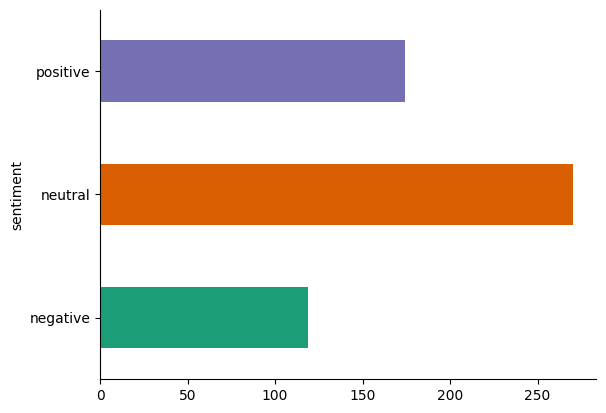

In [ ]:
# @title sentiment

from matplotlib import pyplot as plt
import seaborn as sns
df_russian_sentiment_tweet_copy2.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
print(true_labels.isna().sum())  # Check NaN in true labels
print(predicted_labels.isna().sum())

0
563


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

#
true_labels = df_russian_sentiment_tweet_copy2['sentiment'].map({'negative': 0,'positive': 2})
predicted_labels = df_russian_sentiment_tweet_copy2['predicted_sentiment'].map({'negative': 0, 'positive': 2}).fillna(1)
# Calculate  metrics
f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)


print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

F1 Score: 0.3108881207900567
Precision: 0.22999094548678262
Recall: 0.47957371225577267
Accuracy: 0.47957371225577267


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Further Fine Tuning

Run fine-tuning for augmented data

Augment Train data

In [66]:
import swifter  # Make sure swifter is installed
import pandas as pd
import json
import uuid

# Create an instance of the DataAugmentor class
augmentor = DataAugmentor("ru")  # Assuming 'ru' for Russian

# Load data from JSON file
with open('/content/drive/MyDrive/Colab Notebooks/sentiment-analysis-in-russian/train.json', 'r') as f:
    data = json.load(f)

df_russian_sentiment_tweets2 = pd.DataFrame(data)
df_russian_sentiment_tweets2 = df_russian_sentiment_tweets2[df_russian_sentiment_tweets2['text'].str.len() <= 512]

df_to_augment = df_russian_sentiment_tweets2.copy()

def augment_row(row):
    new_rows = []
    original_text = row['text']
    augmented_texts = augmentor.replace_word_with_synonym(original_text)

    for augmented_text in augmented_texts:
        if augmented_text != original_text:  # Add only if text is modified
            new_id = uuid.uuid4().int  # Generate unique ID
            new_row = row.copy()  # Copy original row
            new_row['id'] = new_id  # Assign new ID
            new_row['text'] = augmented_text  # Update with augmented text
            new_row['sentiment'] = row['sentiment']
            new_rows.append(new_row)

    return new_rows

augmented_rows = df_to_augment.swifter.apply(augment_row, axis=1)

flat_new_rows = [item for sublist in augmented_rows if sublist for item in sublist]

df_to_augment = pd.concat([df_to_augment, pd.DataFrame(flat_new_rows)], ignore_index=True)
df_russian_sentiment_tweets2 = df_russian_sentiment_tweets2.iloc[563:]

display(df_to_augment)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Pandas Apply:   0%|          | 0/563 [00:00<?, ?it/s]

,text,id,sentiment
0,"""Самрук-Энерго"" в I квартале почти вдвое снизи...",1983,negative
1,"/KASE, 29.12.16/ – АО ""KEGOC"" (Астана), ценные...",2032,negative
2,Оплачивайте без комиссий «Казахтелеком» на сай...,2054,positive
3,"03.02.2017, 12:40\nНацбанк ставит для себя при...",2055,positive
4,"10.01.2017, 19:11\nСуд зарегистрировал заявлен...",2071,negative
...,...,...,...
3372,В ЕНПФ назначен новый председатель правления. ...,238523684021034673527347499904538094533,neutral
3373,В ЕНПФ назначен новый председатель правления. ...,89810488320474108618459309211632767996,neutral
3374,В ЕНПФ назначен новый председатель правления. ...,143588217067947952988229083109690842403,neutral
3375,В ЕНПФ назначен новый председатель правления. ...,163556881971185298053777617831514942745,neutral


Run random_deletion on augmented data to increase training data size for fine-tuning

In [ ]:
!pip install transformers datasets
import pandas as pd
import json
from transformers import AutoModelForMaskedLM, AutoTokenizer
import random
import uuid
import nltk
from nltk.tokenize import word_tokenize
import swifter

nltk.download('punkt')

augmentor = DataAugmentor("ru")

def augment_row(row):
    augmented_rows = []
    original_text = row['text']

    # Apply random_deletion
    words = word_tokenize(original_text)  # Tokenize the text
    augmented_text = augmentor.random_deletion(words)  # Apply random_deletion
    if augmented_text != original_text:  # Add only if text is modified
        new_id = uuid.uuid4().int  # Generate unique ID
        new_row = row.copy()
        new_row['id'] = new_id
        new_row['text'] = augmented_text
        new_row['sentiment'] = row['sentiment']
        augmented_rows.append(new_row)

    # Apply replace_word_with_synonym
    augmented_texts = augmentor.replace_word_with_synonym(original_text)
    for augmented_text in augmented_texts:
        if augmented_text != original_text:  # Add only if text is modified
            new_id = uuid.uuid4().int
            new_row = row.copy()
            new_row['id'] = new_id
            new_row['text'] = augmented_text
            new_row['sentiment'] = row['sentiment']
            augmented_rows.append(new_row)

    return augmented_rows

augmented_rows = df_to_augment.swifter.apply(augment_row, axis=1)
flat_new_rows = [item for sublist in augmented_rows if sublist for item in sublist]
df_to_augment = pd.concat([df_russian_sentiment_tweets2, pd.DataFrame(flat_new_rows)], ignore_index=True)

display(df_to_augment)

Fine tune again & run test

# Phase 2: Fine tune "fine_tuned_ru_model" further

In [67]:
import pandas as pd
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer
from sklearn.model_selection import train_test_split
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


model_name = "fine_tuned_rubert_model"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df_to_augment['label'] = df_to_augment['sentiment'].map(label_mapping)
df_to_augment = df_to_augment.copy()

dataset = Dataset.from_pandas(df_to_augment[['text', 'label']])

def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

encoded_dataset = dataset.map(preprocess_function, batched=True)

train_test_split = encoded_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    report_to="none",  # Disable Weights & Biases integration
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=1,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    dataloader_num_workers=2,
    max_steps=2,
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

train_results = trainer.train()
eval_results = trainer.evaluate()

print(eval_results)

trainer.train()

model.save_pretrained("phase2_fine_tuned_rubert_model")
tokenizer.save_pretrained("phase2_fine_tuned_rubert_model")

Map:   0%|          | 0/3377 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,1.921815,0.250000,0.195121,0.352457,0.250000


{'eval_loss': 1.9218146800994873, 'eval_accuracy': 0.25, 'eval_f1': 0.19512086894160147, 'eval_precision': 0.3524571487774623, 'eval_recall': 0.25, 'eval_runtime': 342.2337, 'eval_samples_per_second': 1.975, 'eval_steps_per_second': 0.988, 'epoch': 0.0014803849000740192}


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,1.891014,0.251479,0.197925,0.345664,0.251479


('phase2_fine_tuned_rubert_model/tokenizer_config.json',
 'phase2_fine_tuned_rubert_model/special_tokens_map.json',
 'phase2_fine_tuned_rubert_model/vocab.txt',
 'phase2_fine_tuned_rubert_model/added_tokens.json',
 'phase2_fine_tuned_rubert_model/tokenizer.json')

# Run tests on Tweets Again to see if there is a difference

In [73]:
import pandas as pd
import swifter
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

model_path = "phase2_fine_tuned_rubert_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

sentiment_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer)
russian_tweet_set_copy = russian_tweet_set.head(1000).copy()

def get_sentiment(row):
    content = row['content']
    language = row['language']

    if language == 'English':
        doc = nlp_en(content)
        sentiment = extract_sentiment(doc, 'English')
        return sentiment

    elif language == 'Russian':
        sentiment_result = sentiment_pipeline(content)[0]['label']

        if sentiment_result == 'NEGATIVE':
            return 'negative'
        elif sentiment_result == 'NEUTRAL':
            return 'neutral'
        elif sentiment_result == 'POSITIVE':
            return 'positive'

    return None

russian_tweet_set_copy['sentiment'] = russian_tweet_set_copy.swifter.apply(get_sentiment, axis=1)

display(russian_tweet_set_copy)

Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

,content,region,language,publish_date,harvested_date,following,followers,post_type,sentiment
0,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,NaN,positive
1,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,NaN,neutral
2,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,RETWEET,positive
3,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,NaN,neutral
4,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,RETWEET,neutral
...,...,...,...,...,...,...,...,...,...
4043,Лондонская полиция соревнуется в танцах с жите...,Unknown,Russian,6/30/2017 16:54,6/30/2017 17:31,2833,11360,NaN,negative
4044,Полковника СК подозревают в получении взяток щ...,Unknown,Russian,6/30/2017 8:12,6/30/2017 8:24,2818,11342,NaN,positive
4045,В Оренбурге офицер получил условный срок за до...,Unknown,Russian,6/30/2017 9:18,6/30/2017 10:49,2819,11345,NaN,negative
4046,"""Путин лично контролирует лечение онкобольной ...",Unknown,Russian,6/30/2017 9:45,6/30/2017 10:31,2819,11343,NaN,negative


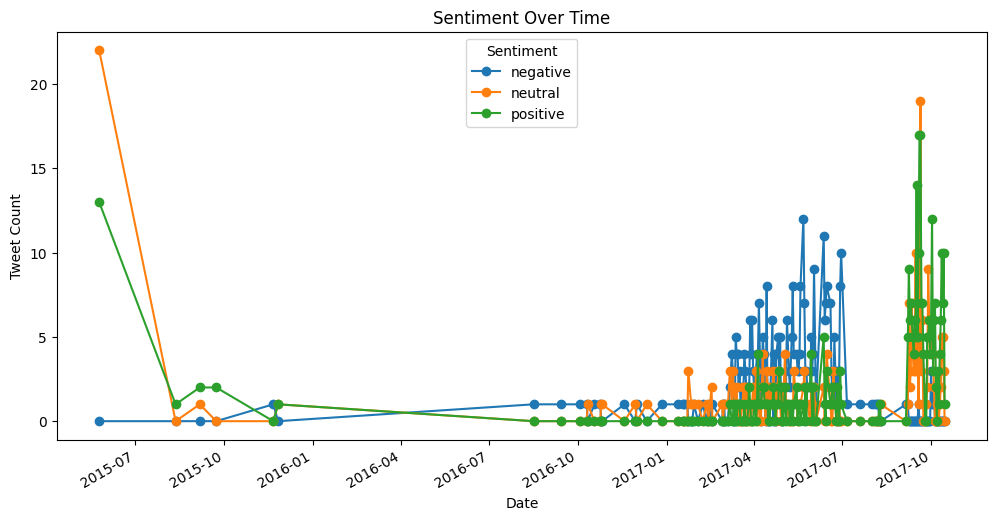

In [74]:
russian_tweet_set_copy['publish_date'] = pd.to_datetime(russian_tweet_set_copy['publish_date'])
russian_tweet_set_copy.set_index('publish_date', inplace=True)

daily_sentiment = russian_tweet_set_copy.groupby([pd.Grouper(freq='D'), 'sentiment']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
daily_sentiment.plot(ax=plt.gca(), marker='o', linestyle='-')
plt.title('Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Tweet Count')
plt.legend(title='Sentiment')
plt.show()

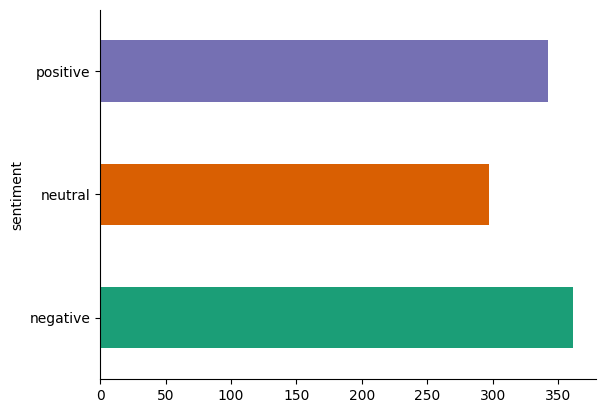

In [75]:
# @title sentiment

from matplotlib import pyplot as plt
import seaborn as sns
russian_tweet_set_copy.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

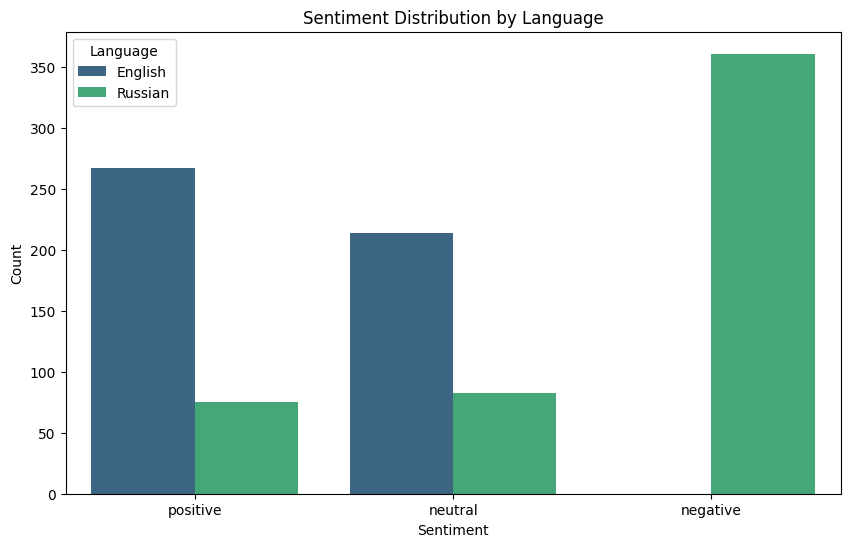

In [76]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
sns.countplot(data=russian_tweet_set_copy, x='sentiment', hue='language', palette='viridis')
plt.title('Sentiment Distribution by Language')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend(title='Language')
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
russian_tweet_set_copy['sentiment_numeric'] = russian_tweet_set_copy['sentiment'].map(sentiment_mapping)

plt.figure(figsize=(12, 6))
plt.scatter(russian_tweet_set_copy.index, russian_tweet_set_copy['sentiment_numeric'],
            c=russian_tweet_set_copy['sentiment_numeric'], cmap='viridis', alpha=0.6)

plt.title('Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.yticks([-1, 0, 1], ['Negative', 'Neutral', 'Positive'])
plt.colorbar(label='Sentiment')
plt.show()

# UNIT TESTS



Data Processor Unit Tests

In [ ]:
import unittest

class TestDataPreprocessor(unittest.TestCase):

    def setUp(self):
        self.preprocessor_en = DataPreprocessor(lang='en')
        self.preprocessor_ru = DataPreprocessor(lang='ru')

    def test_clean_text(self):
        text = "THiS %$ is a test for  #unit test"
        cleaned_text = self.preprocessor_en.clean_text(text)
        expected = "test test"  # Remove stop words, symbols, etc.
        self.assertEqual(cleaned_text, expected)

    def test_remove_special_chars(self):
        text = "Test @this characters and urls https://exampleurl.com"
        cleaned_text = self.preprocessor_en.remove_special_chars(text)
        expected = "Test  characters and urls "
        self.assertEqual(cleaned_text, expected)

    def test_spell_check(self):

        text = "tht exmpl works"
        corrected_text = self.preprocessor_en.spell_check(text)
        expected = "the example works"
        self.assertEqual(corrected_text, expected)

    def test_apply_encoding(self):
        text = "Hello World! 🌍"
        encoded_text = self.preprocessor_en.apply_encoding(text)
        expected = "Hello World! 🌍"  # UTF-8 encoding should keep emoji intact
        self.assertEqual(encoded_text, expected)

    def test_remove_stop_words_en(self):
        text = "This is a sample text with stop words"
        filtered_text = self.preprocessor_en.remove_stop_words(text)
        expected = "This sample text stop words"
        self.assertEqual(filtered_text, expected)

    def test_remove_stop_words_ru(self):
        text = "Это пример текста с стоп словами"
        filtered_text = self.preprocessor_ru.remove_stop_words(text)
        expected = "Это пример текста стоп словами"  # 'с' is a stop word in Russian
        self.assertEqual(filtered_text, expected)



In [ ]:
# Create a test suite
suite = unittest.TestSuite()

# Add tests to the suite
suite.addTest(unittest.makeSuite(TestDataPreprocessor))

# Create a test runner and run the suite
runner = unittest.TextTestRunner()
result = runner.run(suite)